In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,LSTM
from sklearn import metrics
from datetime import timedelta, date, datetime
import time

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv
Saving Global DataBase3.csv to Global DataBase3.csv


In [3]:
df1=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True, dayfirst = True )

df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst = True )


df1 = df1.loc['2017-01-01':'2020-12-31']
df2 = df2.loc['2017-01-01':'2020-12-31']

index = pd.date_range(start='2017-01-01', end='2022-02-28', freq="1d")
columns = ["datetime_per_month", 'Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA','Electricity Consumption (MWh)']

df = pd.DataFrame(np.nan, index=range(0,index.size), columns=columns)
df["datetime_per_month"] = index
df.set_index("datetime_per_month", inplace=True)

df = df.resample("M").mean()


columns1 = ['Electricity Consumption (MWh)']
for column in columns1 : 
    df[column] = df2[column].resample("M").sum()
columns2=['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns2 : 
    df[column] = df2[column].resample("M").mean()
df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(0):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()


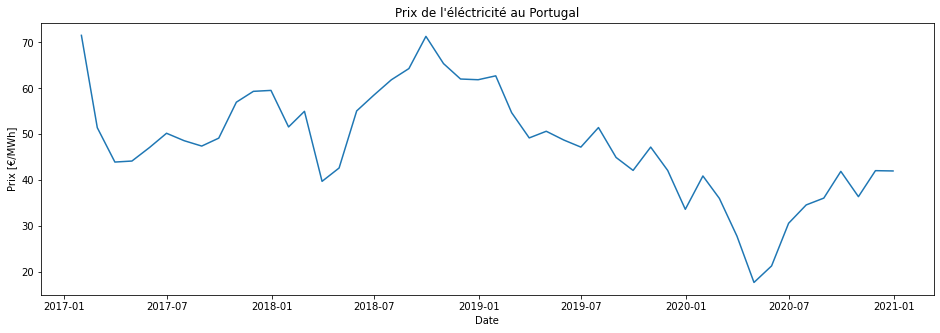

In [4]:
#Plot Price after data cleaning
plt.figure(figsize=(16,5))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Prix [€/MWh]')
plt.plot(df.index, df['Price - PT [€/MWh]'])  
plt.show()

In [11]:
df_u=df[['Price - PT [€/MWh]']].dropna()
df_u

,Price - PT [€/MWh]
datetime_per_month,
2017-01-31,71.517497
2017-02-28,51.430655
2017-03-31,43.956841
2017-04-30,44.178000
2017-05-31,47.121747
2017-06-30,50.220153
2017-07-31,48.604099
2017-08-31,47.434825
2017-09-30,49.161833


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df_u.values)
    
reframed= series_to_supervised(scaled, 19, 2)
reframed.head()

,var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),...,var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1)
19,1.000000,0.252552,-0.025555,-0.017326,0.092214,0.207508,0.147373,0.103863,0.168127,0.459014,...,0.554398,0.258670,0.385221,-0.181667,-0.073689,0.388383,0.514932,0.640017,0.731118,0.991797
20,0.252552,-0.025555,-0.017326,0.092214,0.207508,0.147373,0.103863,0.168127,0.459014,0.546809,...,0.258670,0.385221,-0.181667,-0.073689,0.388383,0.514932,0.640017,0.731118,0.991797,0.771398
21,-0.025555,-0.017326,0.092214,0.207508,0.147373,0.103863,0.168127,0.459014,0.546809,0.554398,...,0.385221,-0.181667,-0.073689,0.388383,0.514932,0.640017,0.731118,0.991797,0.771398,0.646548
22,-0.017326,0.092214,0.207508,0.147373,0.103863,0.168127,0.459014,0.546809,0.554398,0.258670,...,-0.181667,-0.073689,0.388383,0.514932,0.640017,0.731118,0.991797,0.771398,0.646548,0.640812
23,0.092214,0.207508,0.147373,0.103863,0.168127,0.459014,0.546809,0.554398,0.258670,0.385221,...,-0.073689,0.388383,0.514932,0.640017,0.731118,0.991797,0.771398,0.646548,0.640812,0.672295


In [8]:
reframed.loc[41,:].values

array([ 0.64654828,  0.64081196,  0.67229463,  0.3744183 ,  0.16984872,
        0.22368271,  0.15263471,  0.09550169,  0.25376618,  0.01184568,
       -0.09311387,  0.0956476 , -0.0936281 , -0.40800916, -0.13810001,
       -0.31961506, -0.62507542, -1.        , -0.8662612 , -0.52100704,
       -0.37254433])

In [9]:
reframed= series_to_supervised(df_u.values, 19, 2)
reframed.iloc[41,:]

IndexError: ignored

In [ ]:
#values = reframed_differenced.values
values = reframed.values
n_train_days=  int(len(values) * 0.5)
n_val_days= int(len(values) * 0.75)
train = values[:n_train_days, :]
val= values[n_train_days:n_val_days, :]
test = values[n_val_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(test_X)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(test_X)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

index_test=df_u['Price - PT [€/MWh]'][n_val_days:]

In [ ]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
# fit network
start_time=time.time()
history = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(val_X, val_y), verbose=0, shuffle=False)
exec_time= time.time()-start_time

In [ ]:
# plot history
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.gca().set(title='Courbes d\'apprentissage .', xlabel='Epochs', ylabel='Erreur')
plt.legend()

In [ ]:
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)
#Transform test to be 2D
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
test_X

In [ ]:
test_X=pd.DataFrame(test_X)
# invert scaling for forecast
test_X[0]= yhat
inv_yhat = scaler.inverse_transform(test_X)
inv_yhat = inv_yhat[:,0]

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X[0]= test_y
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [ ]:
inv_y

In [ ]:
inv_yhat

In [ ]:
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

In [ ]:
plt.figure(figsize=(32,5))
plt.scatter(index_test[20:].index, inv_y, color='blue')
plt.scatter(index_test[20:].index, inv_yhat, color='red')
plt.legend(('Actual', 'Forecast'))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Price [€/MWh]')

In [ ]:
index_test[19:].index.shape

In [ ]:
inv_yhat.shape

In [ ]:
inv_y

In [ ]:
df.loc['2022', 'Price - PT [€/MWh]'].plot()
plt.show()

In [ ]:
# define input
scaled = [[ -0.6021526 , -0.594519  , -0.66674503, -0.71634698,
       -0.70329386, -0.72052086, -0.73437389, -0.69599953, -0.75465795,
       -0.78010747, -0.73433851, -0.78023216, -0.85646008, -0.79101526,
       -0.83502718, -0.9090921 , -1.        , -0.96757237, -0.88385866,
       -0.84786093, -0.9090921]]
scaled = np.array(scaled)

scaled = scaled.reshape((scaled.shape[0], 1, scaled.shape[1]))
# get prediction for new input
new_output = model.predict(scaled)
# summarize input and output
print(scaled, new_output)

In [ ]:
mars = scaler.inverse_transform([[0.24474363]])
mars